# Host Filtering Assessment

Filtering the barley genome from NT metagenomic reads was observed to bias taxonomic classifications, with a reduction in Firmicutes. Let's try to work out why...

## Barley Genome

We can use the Morex V3 assembly which includes PacBio HiFi reads, and so is less likely to have bacterial contaminants in the assembly than Morex V2 which was used for the previous analysis. 

In [2]:
import urllib3
import shutil
import subprocess
from multiprocessing import Pool
import os
import re
from glob import glob
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import SeqIO
import sys
import gzip
import shutil
from IPython.display import Image,IFrame

samples={'bulk':['2000','2001','2002'], 'elite':['2023','2024','2025']}


In [ ]:
os.mkdir('reference')
http = urllib3.PoolManager()

fasta_url='https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/b6e6a2e5-2746-4522-8465-019c8f56df7f/1/DOWNLOAD'
annot_url='https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD'
fasta_path='reference/Barley_MorexV3_psuedomolecules.fasta'
annot_path='reference/Barley_MorexV3_psuedomolecules.gff3'
    
print('Downloading {}'.format(fasta_url))
with http.request('GET',fasta_url, preload_content=False) as resp, open(fasta_path, 'wb') as out_file:
    shutil.copyfileobj(resp, out_file)
r.release_conn()

print('Downloading {}'.format(annot_url))
with http.request('GET',annot_url, preload_content=False) as resp, open(annot_path, 'wb') as out_file:
    shutil.copyfileobj(resp, out_file)
r.release_conn()

Now we can build a BWA index...

In [ ]:
os.mkdir('bwa')
os.mkdir('logs')
bwa_path='bwa/MorexV3'
os.symlink('../'+fasta_path,bwa_path)

process=subprocess.Popen(['bwa','index',bwa_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE)
stdout,stderr = process.communicate()

with open('logs/bwa_morex_v3_index.out','w') as stdout_file:
    stdout_file.write(stdout.decode('UTF-8'))

with open('logs/bwa_morex_v3_index.err','w') as stderr_file:
    stderr_file.write(stderr.decode('UTF-8'))

...and symlink in the original QC'd fastq files...

In [ ]:
files=glob('../GO_enrichment/read_qc/trim_galore/*gz')
if not os.path.exists('fastq'):
    os.mkdir('fastq')

fq_re=re.compile(r'([0-9]{4}_[12])_val_[12].fq.gz')
for file in files:
    m=re.search(fq_re,file)
    os.symlink('../'+file,'fastq/{}.fq.gz'.format(m.group(1)))

In [1]:
%%bash
cat bin/align_and_filter.sh
#qsub bin/align_and_filter.sh

#!/bin/env bash

#$ -pe smp 24
#$ -jc long
#$ -mods l_hard h_vmem 32G
#$ -j y
#$ -o logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -cwd 
#$ -t 1-12:1

readarray -t samples < <(ls -1 fastq|cut -f1 -d_|sort -u)
sample=${samples[$SGE_TASK_ID-1]}

mkdir -p bwa_alignments
mkdir -p filtered_fastq

cp -rv bwa/* $TMPDIR/
cp -v fastq/${sample}* $TMPDIR
bwa mem -t 24 -M $TMPDIR/MorexV3 $TMPDIR/${sample}_1.fq.gz $TMPDIR/${sample}_2.fq.gz |\
	samtools view -b -o $TMPDIR/${sample}.bam
samtools sort -@ 24 --write-index -o $TMPDIR/${sample}.sorted.bam $TMPDIR/${sample}.bam
samtools fastq -F 12 -f 2 -N -1 $TMPDIR/${sample}.filtered_1.fq.gz -2 $TMPDIR/${sample}.filtered_2.fq.gz \
	-0 /dev/null $TMPDIR/${sample}.sorted.bam

cp -v ${TMPDIR}/${sample}.sorted* bwa_alignments
cp -v ${TMPDIR}/${sample}.filtered* filtered_fastq

### Mapping Results

In [16]:
tot_re=re.compile(r'^([0-9]+) \+ [0-9]+ in total')
map_re=re.compile(r'([0-9]+) \+ [0-9]+ mapped')

labels=[]
totals=[]
mapped=[]

for sample in samples.keys():
    for rep in samples[sample]:   
        print(rep)
        labels.append(rep)
        flagstat=pysam.flagstat("bwa_alignments/{}.sorted.bam".format(rep))
        m=re.search(tot_re,flagstat)
        totals.append(m.group(1))
    
        m=re.search(map_re,flagstat)
        mapped.append(m.group(1))
        


2000
2001
2002
2023
2024
2025


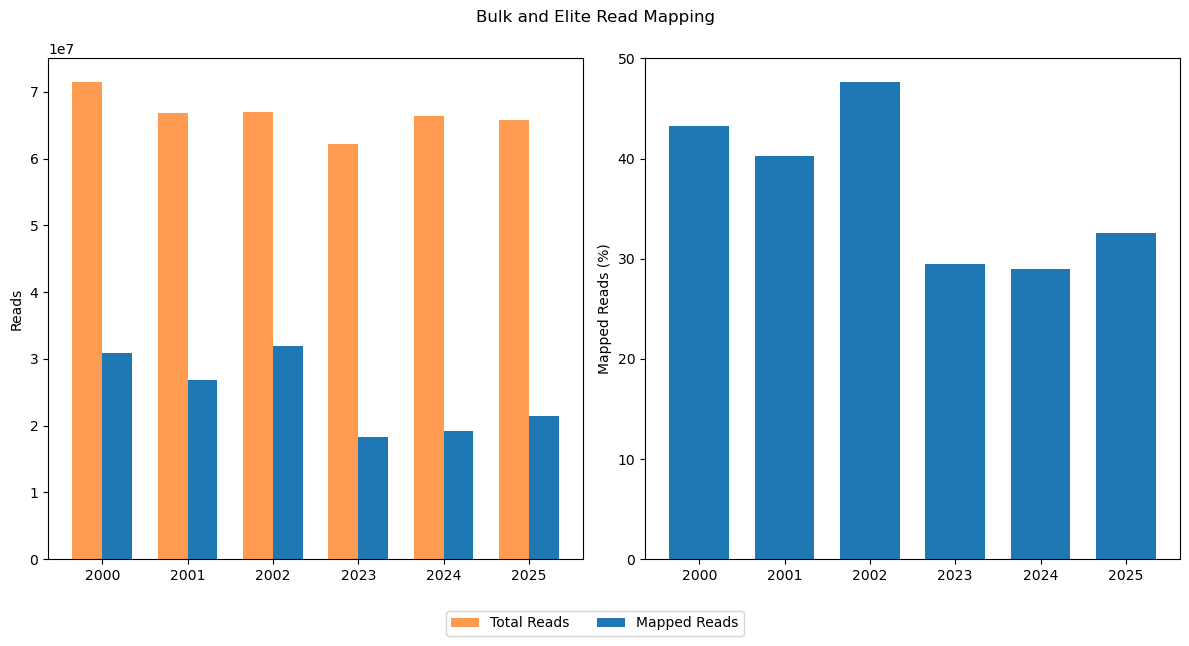

In [17]:

totals=[int(x) for x in totals]
mapped=[int(x) for x in mapped]
percents=[]
for i in range(6):
    percents.append((mapped[i]/totals[i])*100)

x=np.arange(len(labels))
width=0.35

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

fig, (ax1,ax2) = plt.subplots(1,2)
rects1 = ax1.bar(x - width/2, totals, width, color=(1, 0.607, 0.314, 1),label='Total Reads')
rects2 = ax1.bar(x + width/2, mapped, width, label='Mapped Reads')

ax1.set_ylabel('Reads')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.ticklabel_format(axis='y',style='sci')

rects3 = ax2.bar(x,percents,width*2)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylabel('Mapped Reads (%)')


fig.suptitle('Bulk and Elite Read Mapping')
fig.legend(loc='upper center',bbox_to_anchor=(0.5,-0.01),ncol=2)
fig.tight_layout()

plt.show()

## Filtering

So far we have separate the set of reads which aligned to the morexV3 assembly. We can do some additional filtering to capture some other sets for comparison.

* unmapped reads (-f 12) - as for NT paper
* unmapped reads (-f 4), but not with requirement for paired alignment
* unmapped reads or those with a MAPQ<20

Let's see what kind of difference we have on sample sizes after that....lets just focus on elite samples.

In [1]:
def count_reads(file):
    count=0
    with gzip.open(file,'rt') as handle:
        for line in handle:
            count=count+1
    return(count/4)


def get_counts(group):
    for sample in samples[group]:
        unfiltered[group].append(count_reads('fastq/{}_1.fq.gz'.format(sample)))
        mapped[group].append(count_reads('filtered_fastq/morex3_aligned/{}.filtered_1.fq.gz'.format(sample)))
        unmapped[group].append(count_reads('filtered_fastq/morex3_unaligned/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_10_filtered[group].append(count_reads('filtered_fastq/mapq_10/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_15_filtered[group].append(count_reads('filtered_fastq/mapq_15/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_20_filtered[group].append(count_reads('filtered_fastq/mapq_20/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_25_filtered[group].append(count_reads('filtered_fastq/mapq_25/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_filtered[group].append(count_reads('filtered_fastq/mapq_30/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_35_filtered[group].append(count_reads('filtered_fastq/mapq_35/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_40_filtered[group].append(count_reads('filtered_fastq/mapq_40/{}_unmapped_1.fq.gz'.format(sample)))

In [6]:
unfiltered={'elite': [],'bulk': []}
mapped={'elite': [],'bulk': []}
unmapped={'elite': [],'bulk': []}
mapq_10_filtered={'elite': [],'bulk': []}
mapq_15_filtered={'elite': [],'bulk': []}
mapq_20_filtered={'elite': [],'bulk': []}
mapq_25_filtered={'elite': [],'bulk': []}
mapq_30_filtered={'elite': [],'bulk': []}
mapq_35_filtered={'elite': [],'bulk': []}
mapq_40_filtered={'elite': [],'bulk': []}

get_counts('bulk')
get_counts('elite')

In [12]:
bulk_fastq_counts=pd.DataFrame(list(zip(unfiltered['bulk'],mapped['bulk'],
                                  unmapped['bulk'],mapq_10_filtered['bulk'],
                                  mapq_15_filtered['bulk'],mapq_20_filtered['bulk'],
                                  mapq_25_filtered['bulk'],mapq_30_filtered['bulk'],
                                  mapq_30_filtered['bulk'],mapq_40_filtered['bulk'])),
                         columns=['unfiltered','mapped','unmapped','mapq_10','mapq_15','mapq_20','mapq_25','mapq_30','mapq_35','mapq_40'])
bulk_fastq_counts.to_csv('bulk_fastq_counts.txt',sep="\t",index=False)


elite_fastq_counts=pd.DataFrame(list(zip(unfiltered['elite'],mapped['elite'],
                                   unmapped['elite'],mapq_10_filtered['elite'],mapq_15_filtered['elite'],mapq_20_filtered['elite'],
                                   mapq_25_filtered['elite'],mapq_30_filtered['elite'],mapq_35_filtered['elite'],mapq_40_filtered['elite'])),
                         columns=['unfiltered','mapped','unmapped','mapq_10','mapq_15','mapq_20','mapq_25','mapq_30','mapq_35','mapq_40'])
elite_fastq_counts.to_csv('elite_fastq_counts.txt',sep="\t",index=False)

Results were plotted in the `host_filter.Rmd` notebook.
![images/host_filtering.png](images/host_filtering.png)

## Kraken

We can now classify both the filtered and unfiltered reads with Kraken2 and the full database (including plants, fungi, protozoa etc.) created with /cluster/db/jabbott/training_data/bin/kraken_build.sh on 17th Oct 2021.

In [14]:
%%bash
cat bin/kraken.sh

#!/bin/env bash

#$ -pe smp 24
#$ -mods l_hard mfree 96G
#$ -j y
#$ -o logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -cwd
#$ -t 1-12

set -e

# Runs kraken2 against paired fastq reads, where read filenames start with the sample followed by a '_'.

# This script is designed to be run as an array job on an SGE cluster 
# which has local disk storage available on execution nodesaccessed via $TMPDIR, 

usage="Usage: $0 -i /path/to/input/fastq/directory -o /path/to/output/directory -d path/to/kraken_db" 

while getopts "i:o:d:" opt; do
  case "${opt}" in
	i )
		in_dir=${OPTARG}
		;;
	o )
	  out_dir=${OPTARG}
	  ;;
	d )
		db=${OPTARG}
	  ;;
	\? )
		echo ${usage}
	  ;;
	: )
		echo "Invalid option: $OPTARG requires an argument" 1>&2
	;;
  esac
done

if [[ ! -e "${in_dir}" ]]; then
	echo "Specificed input directory (${indir}) does not exist"
	exit
fi

if [[ ! -e "${db}" ]]; then
	echo "Specificed kraken database (${db}) does not exist"
	exit
fi

if [[ -z "${SGE_TASK_ID}" ]]; then
  echo "This script shoul

### Create Krona outputs

Requires Kraken2 environment

In [ ]:
%%bash
mkdir -p kraken/krona
cd kraken/nt_unfiltered
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_unfiltered_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_unfiltered_elite.html

cd ../nt_morex3_aligned
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_morex3_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_morex3_elite.html

cd ../nt_morex3_unaligned
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_morex3_unaligned_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_morex3_unaligned_elite.html



In [ ]:
%%bash

cd kraken/nt_mapq10
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq10_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq10_elite.html

cd kraken/nt_mapq15
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq15_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq15_elite.html

cd kraken/nt_mapq20
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq20_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq20_elite.html

cd ../nt_mapq25
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq25_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq25_elite.html

cd ../nt_mapq30
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq30_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq30_elite.html



In [4]:
%%bash
cd kraken/nt_mapq_35
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq23_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq35_elite.html

cd ../nt_mapq_40
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq40_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq40_elite.html

Loading taxonomy...
Importing 2000.report.txt...
Importing 2001.report.txt...
Importing 2002.report.txt...
Writing ../krona/nt_mapq23_bulk.html...
Loading taxonomy...
Importing 2023.report.txt...
Importing 2024.report.txt...
Importing 2025.report.txt...
Writing ../krona/nt_mapq35_elite.html...
Loading taxonomy...
Importing 2000.report.txt...
Importing 2001.report.txt...
Importing 2002.report.txt...
Writing ../krona/nt_mapq40_bulk.html...
Loading taxonomy...
Importing 2023.report.txt...
Importing 2024.report.txt...
Importing 2025.report.txt...
Writing ../krona/nt_mapq40_elite.html...


   [ WARNING ]  Score column already in use; not reading scores.
   [ WARNING ]  The following taxonomy IDs were not found in the local
                database and were set to root (if they were recently added to
                NCBI, use updateTaxonomy.sh to update the local database):
                2881398 2864218 2884243 2881428 2881384 2864217 2881385 2881391
                2883512 2881378 2849666 2881427 2881426 2881383 2881377
   [ WARNING ]  Too many query IDs to store in chart; storing supplemental
                files in '../krona/nt_mapq23_bulk.html.files'.
   [ WARNING ]  Score column already in use; not reading scores.
   [ WARNING ]  The following taxonomy IDs were not found in the local
                database and were set to root (if they were recently added to
                NCBI, use updateTaxonomy.sh to update the local database):
                2884243 2843155 2883512 2881426 2880362 2881384 2864217 2881428
                2844166 2864218 2881383 2881398 2881

__Results__

| Bulk | Elite |
|------|-------|
| [Unfilted](kraken/krona/nt_unfiltered_bulk.html) |  [Unfiltered](kraken/krona/nt_unfiltered_elite.html) |
| [Morex3 aligned](kraken/krona/nt_morex3_bulk.html) | [Morex3 aligned](kraken/krona/nt_morex3_elite.html) |
| [Morex3 unaligned](kraken/krona/nt_morex3_unaligned_bulk.html) | [Morex3 unaligned](kraken/krona/nt_morex3_unaligned_elite.html) |
| [MAPQ10](kraken/krona/nt_mapq10_bulk.html) | [MAPQ20](kraken/krona/nt_mapq10_elite.html) |
| [MAPQ15](kraken/krona/nt_mapq15_bulk.html) | [MAPQ25](kraken/krona/nt_mapq15_elite.html) |
| [MAPQ20](kraken/krona/nt_mapq20_bulk.html) | [MAPQ20](kraken/krona/nt_mapq20_elite.html) |
| [MAPQ25](kraken/krona/nt_mapq25_bulk.html) | [MAPQ25](kraken/krona/nt_mapq25_elite.html) |
| [MAPQ30](kraken/krona/nt_mapq30_bulk.html) | [MAPQ30](kraken/krona/nt_mapq30_elite.html) |
| [MAPQ35](kraken/krona/nt_mapq35_bulk.html) | [MAPQ35](kraken/krona/nt_mapq35_elite.html) |
| [MAPQ40](kraken/krona/nt_mapq40_bulk.html) | [MAPQ40](kraken/krona/nt_mapq40_elite.html) |

We can pull out the proportion of eukaryotic and barley DNA with a grep...

In [7]:
%%bash
rm -rf kraken/euk_barley_props.txt
readarray -t sets < <(ls kraken |grep -ve biom -ve krona)
echo -e "Filter\tSample\tEukaryote\tBarley" > kraken/euk_barley_props.txt

for set in ${sets[@]}; do    
    for sample in 2000 2001 2002; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tBulk\t$euk\t$barley" >> kraken/euk_barley_props.txt
    done
    for sample in 2023 2024 2025; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tElite\t$euk\t$barley" >> kraken/euk_barley_props.txt
    done
done

grep: kraken/euk_barley_props_filtered.txt/2000.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2000.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2001.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2001.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2002.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2002.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2023.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2023.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2024.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2024.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2025.report.txt: Not a directory
grep: kraken/euk_barley_props_filtered.txt/2025.report.txt: Not a directory


### Convert to biom

The resulting reports need converting to biom format for importing into phyloseq. Let's copy the results into more helpfully named files so they can be distinguished later on. Use '--max P' to only catch assingments at phylum level or below to remove the large proportion of unclassified reads.

In [9]:
%%bash
mkdir -p kraken/biom
cd kraken/biom
samples=(2000 2001 2002 2023 2024 2025)
for sample in ${samples[@]}; do
    ln -sf ../nt_unfiltered/${sample}.report.txt unfiltered_${sample}.txt
    ln -sf ../nt_morex3_aligned/${sample}.report.txt morex3_aligned_${sample}.txt
    ln -sf ../nt_morex3_unaligned/${sample}.report.txt morex3_unaligned_${sample}.txt
    ln -sf ../nt_mapq10/${sample}.report.txt mapq10_${sample}.txt
    ln -sf ../nt_mapq15/${sample}.report.txt mapq15_${sample}.txt
    ln -sf ../nt_mapq20/${sample}.report.txt mapq20_${sample}.txt
    ln -sf ../nt_mapq25/${sample}.report.txt mapq25_${sample}.txt
    ln -sf ../nt_mapq30/${sample}.report.txt mapq30_${sample}.txt
    ln -sf ../nt_mapq35/${sample}.report.txt mapq35_${sample}.txt
    ln -sf ../nt_mapq40/${sample}.report.txt mapq40_${sample}.txt
done
reports=$(ls *txt)
kraken-biom --fmt json --gzip *.txt

### Abundance and Diversity

The biom results were imported to phyloseq and used to generate abundance and beta-diversity plots (see [host_filter.Rmd](host_filter.Rmd)).


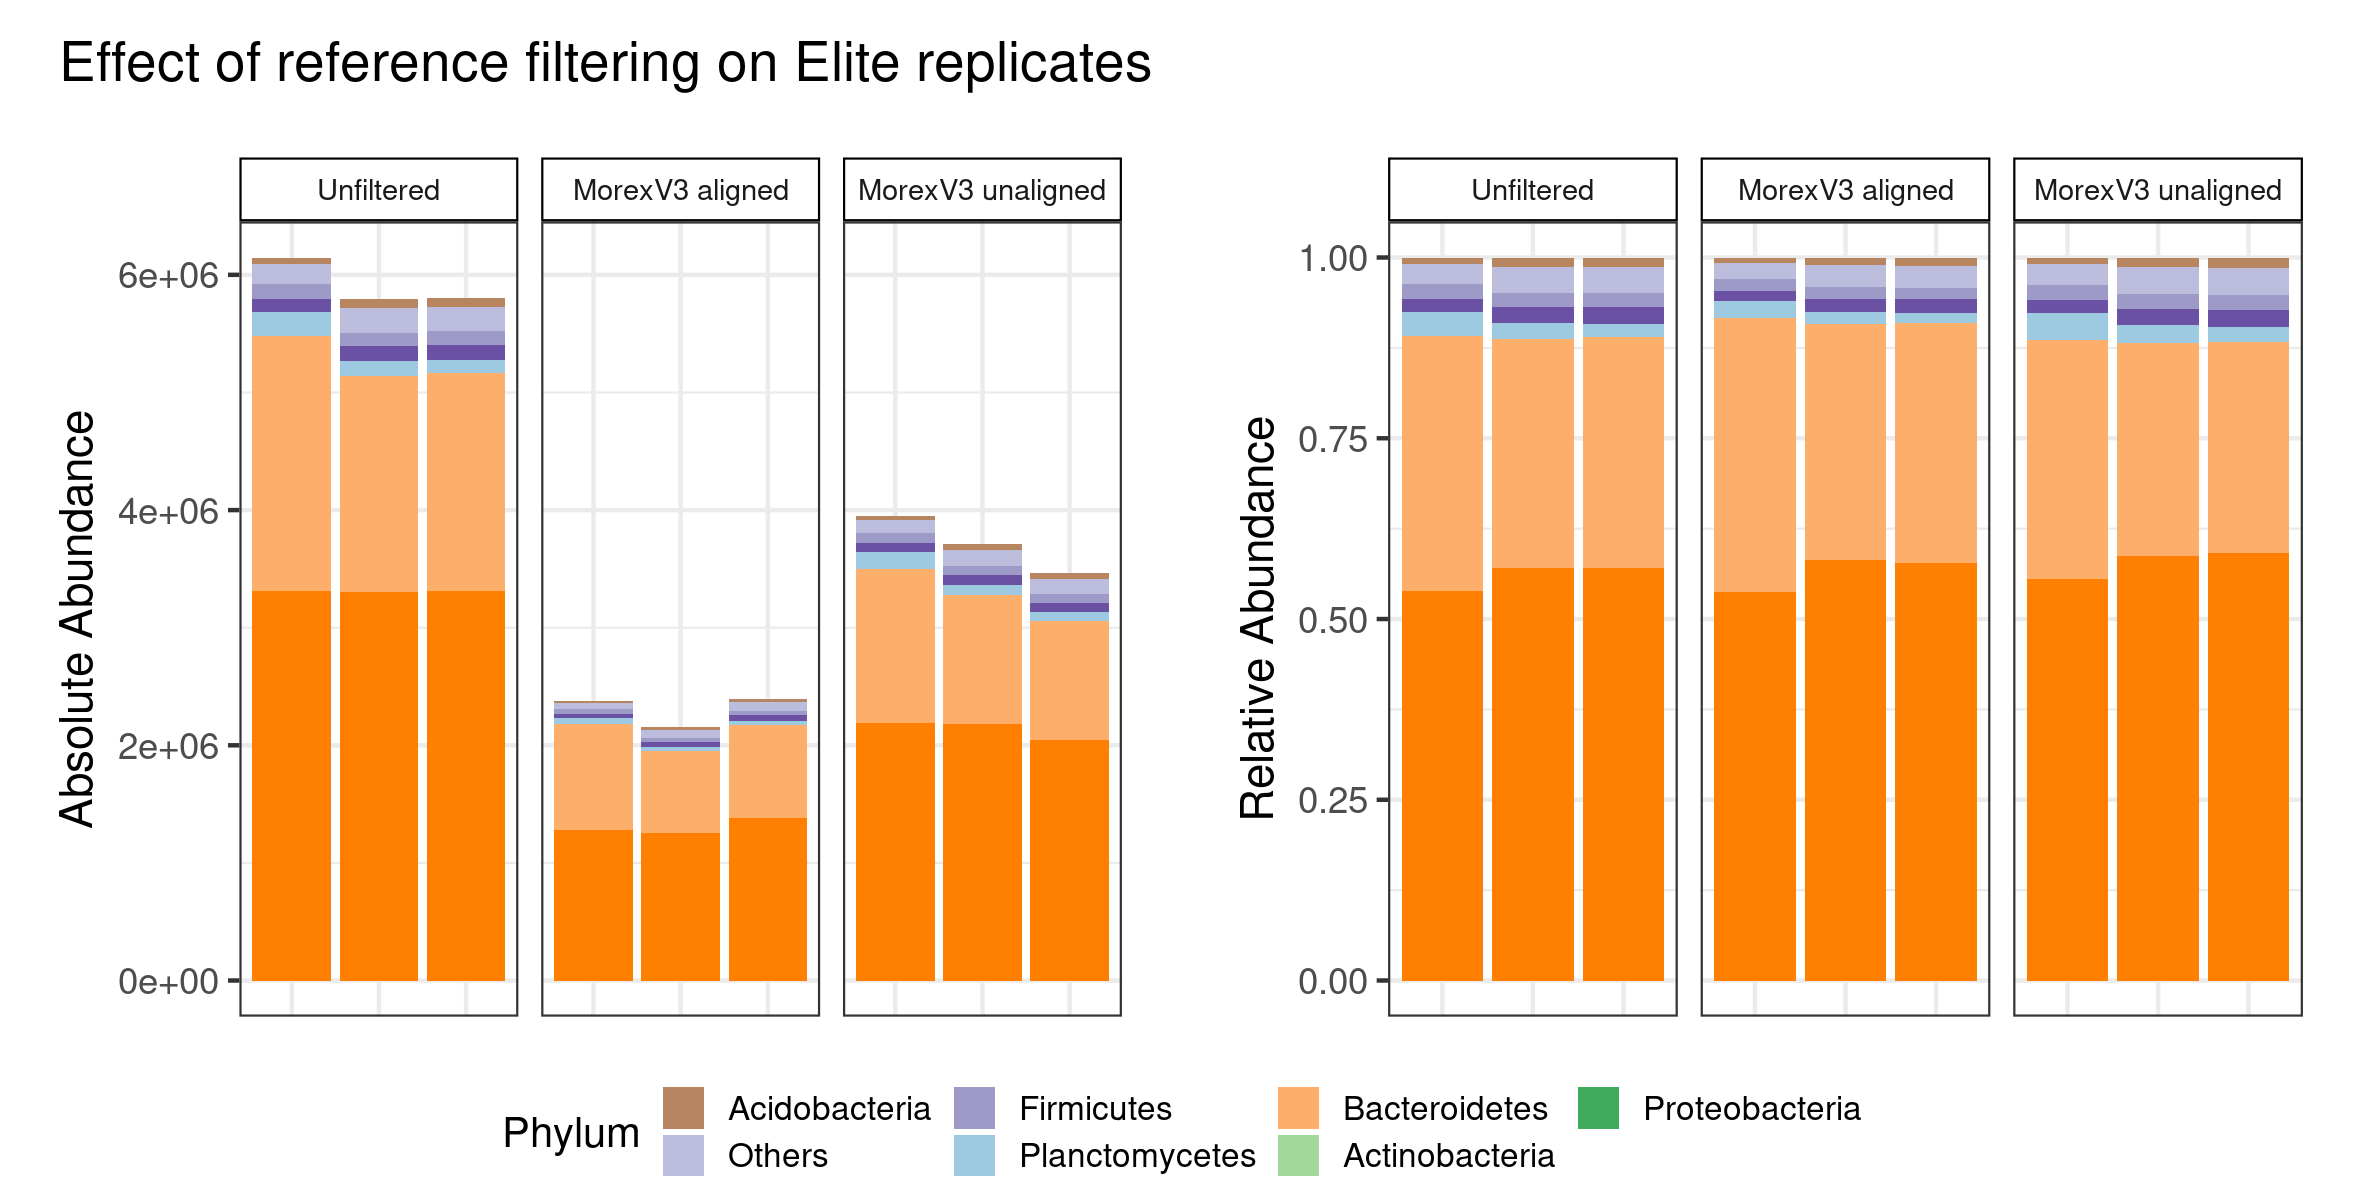

In [1]:
Image(filename='images/phylum_abundance.png', width=800)

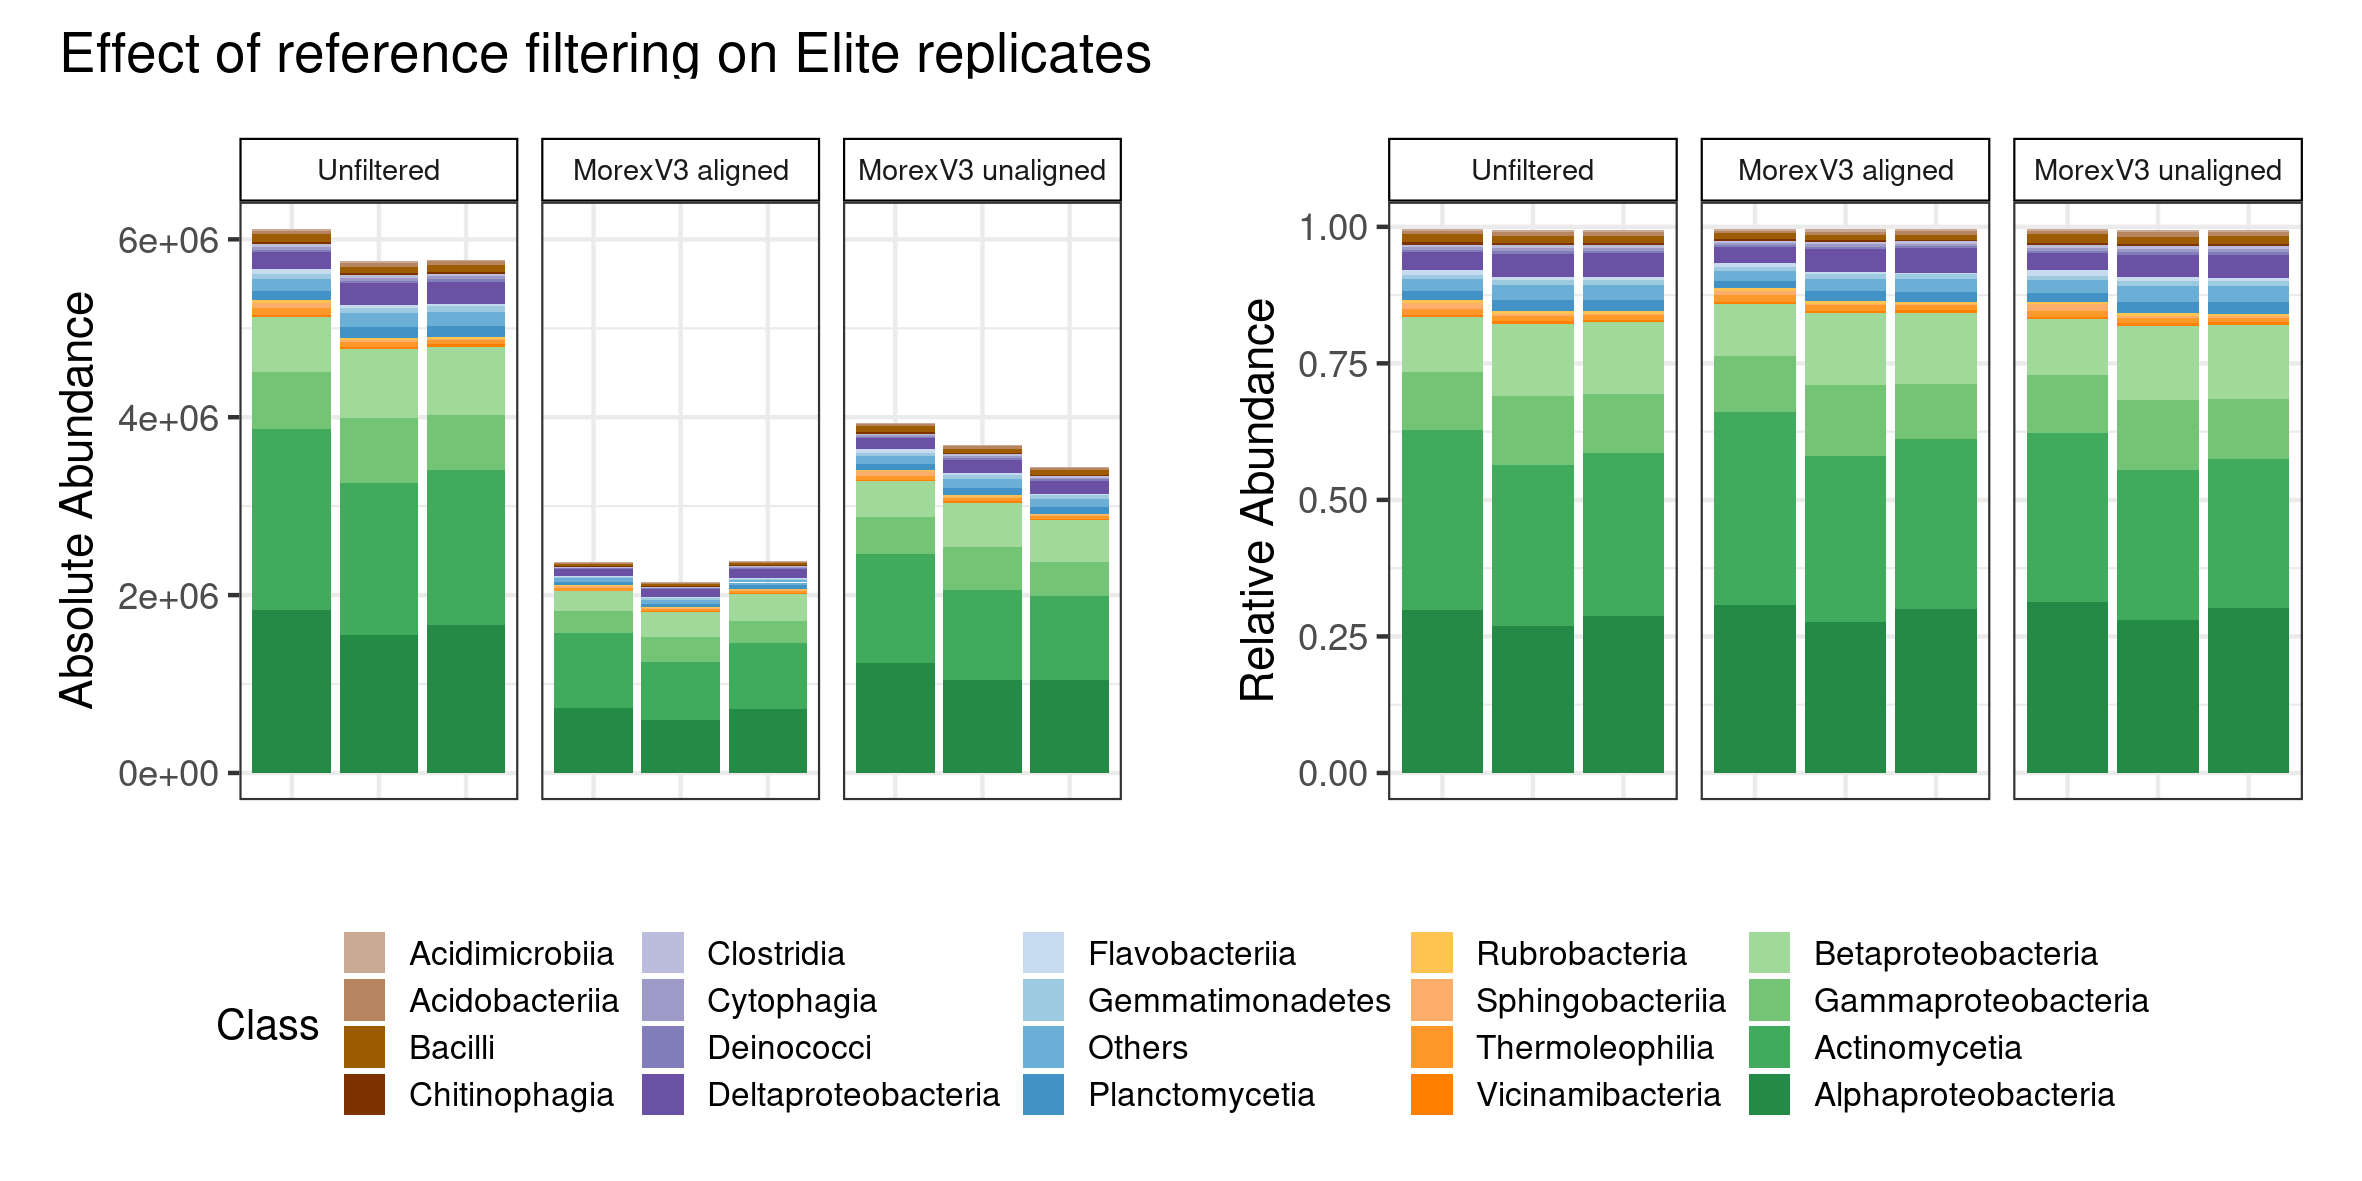

In [13]:
Image(filename='images/class_abundance.png', width=800)

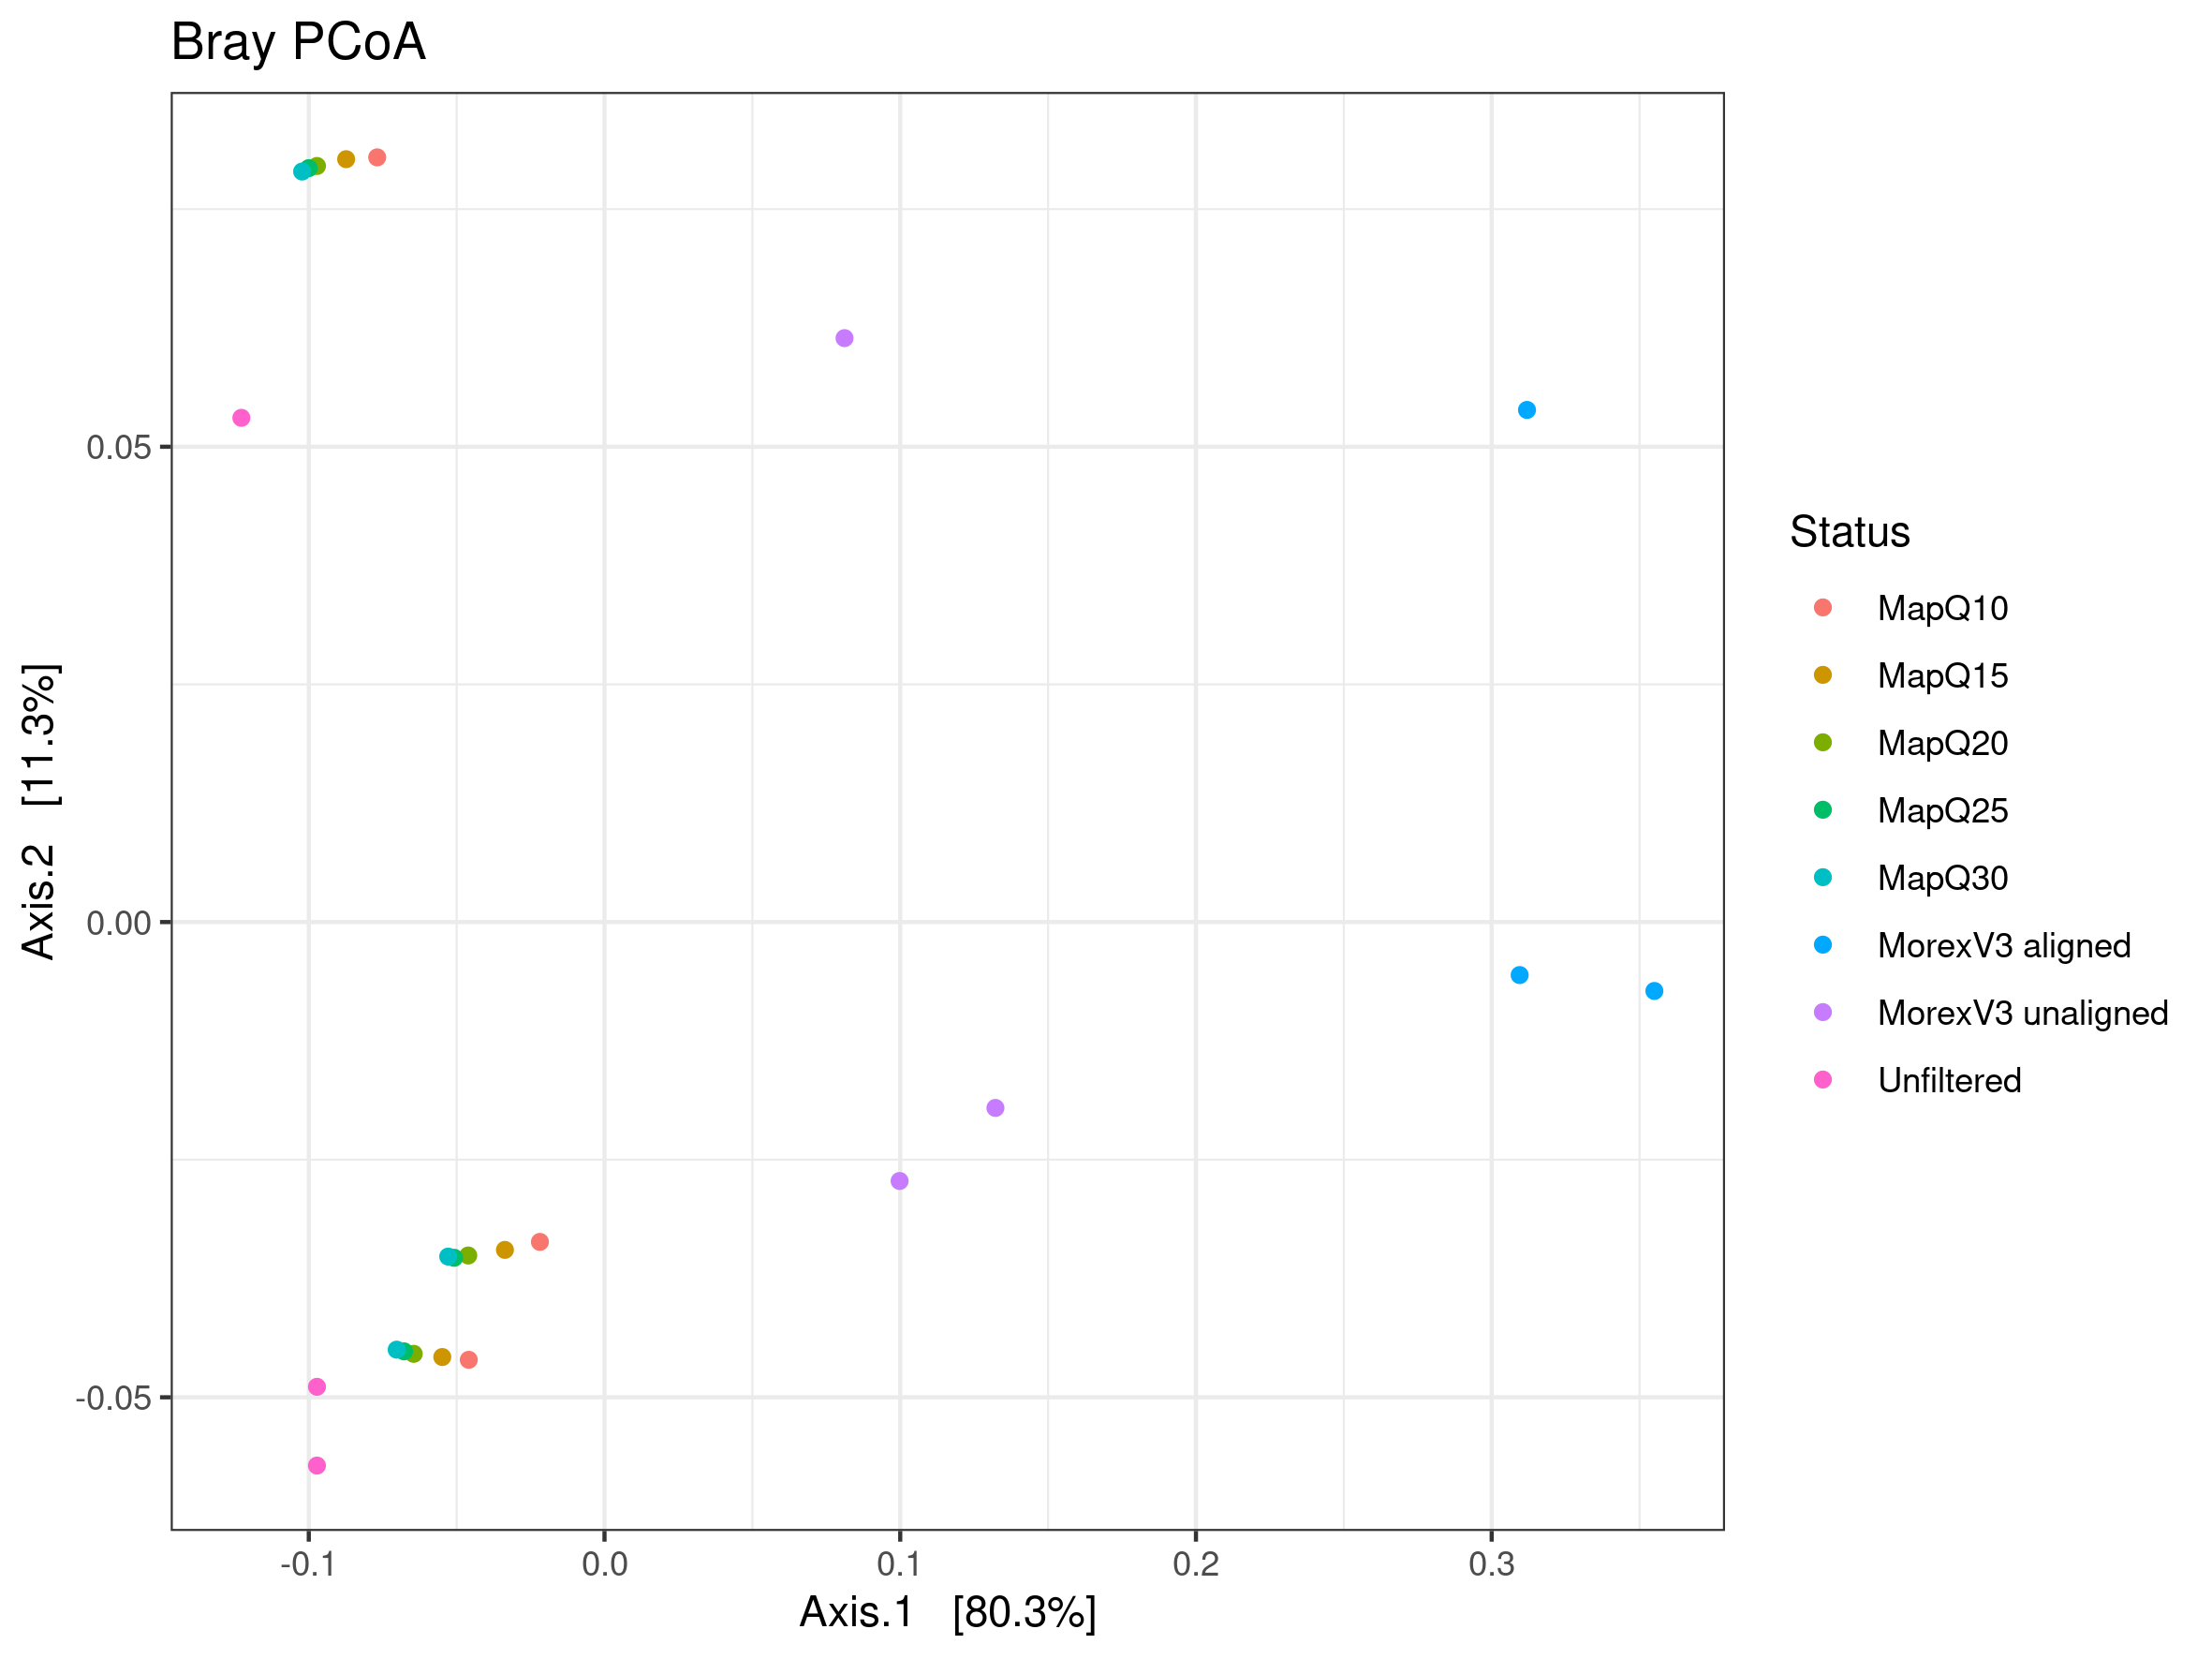

In [2]:
Image(filename='images/bray.png',width=800)

## DESeq2 Analysis

DESeq2 was used to determine any statistically significant changes to the community composition introduced by the filtering process, based upon the kraken2 results. See [host_filter.Rmd](host_filter.Rmd) for the code...

This only looked at bulk and elite samples, since elite is Morex then this should be optimally filtered by alignment. Bulk as expected mainly shows changes in plant species.

In [2]:
bulk_deseq=pd.read_csv('deseq2/bulk.txt',sep="\t")
bulk_deseq

,taxa,taxid,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pre.2000,pre.2001,pre.2002,post.2000,post.2001,post.2002
0,Medicago,3877,1.183987e+05,-2.397232,0.339698,-7.056959,1.701860e-12,1.825099e-09,73868,52666,92400,105471,74966,128028
1,Triticum,4564,7.090361e+06,-2.305467,0.331101,-6.963023,3.330473e-12,1.825099e-09,4650548,3379867,5795182,6273404,4520301,7499573
2,Geosporobacter,390805,1.006955e+02,-1.842569,0.296498,-6.214440,5.150787e-10,1.411316e-07,100,73,85,107,53,89
3,Brachypodium,15367,7.370273e+03,-1.809906,0.314330,-5.757985,8.512398e-09,1.865918e-06,6554,4821,7625,6308,4305,7216
4,Mogibacterium,86331,1.784931e+02,-1.458128,0.325623,-4.477966,7.535773e-06,6.353237e-04,197,143,215,180,85,149
5,Setaria,4554,4.825621e+03,-1.424191,0.288600,-4.934821,8.022439e-07,1.099074e-04,5364,4045,5840,3829,2749,4353
6,Zea,4575,8.038816e+03,-1.372550,0.291772,-4.704185,2.548825e-06,3.103903e-04,9249,6876,9962,6485,4396,7177
7,Panicum,4539,4.302652e+03,-1.356234,0.271575,-4.993949,5.915698e-07,9.262293e-05,5028,3773,5286,3561,2409,3694
8,Homo,9605,1.823806e+05,-1.244964,0.199390,-6.243862,4.268968e-10,1.411316e-07,209346,210294,208995,132190,131857,135838
9,Sorghum,4557,4.014148e+03,-1.236504,0.273783,-4.516362,6.291111e-06,6.152143e-04,4918,3834,5179,3082,2233,3453


In [3]:
elite_deseq=pd.read_csv('deseq2/elite.txt',sep="\t")
elite_deseq

,taxa,taxid,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,pre.2023,pre.2024,pre.2025,post.2023,post.2024,post.2025
0,Blastochloris,59282,4983.233017,-0.398737,0.121450,-3.283141,1.026572e-03,0.039921,7740,7091,7949,3194,2859,3680
1,Polymorphum,991903,1685.836432,-0.388073,0.098087,-3.956401,7.608749e-05,0.016623,2554,2532,2657,1056,1016,1208
2,Alicycliphilus,201096,1367.673883,-0.387803,0.108749,-3.566037,3.624201e-04,0.028359,1877,2280,2136,813,869,981
3,Thermobispora,147067,1741.908430,-0.374820,0.106888,-3.506654,4.537793e-04,0.028374,2771,2687,2577,1096,1095,1178
4,Chelatococcus,28209,4136.936104,-0.369665,0.116961,-3.160584,1.574532e-03,0.047427,6549,6053,6523,2689,2390,2917
5,Starkeya,152053,5597.912921,-0.357750,0.113382,-3.155261,1.603548e-03,0.047427,8845,8290,8868,3603,3217,3965
6,Pannonibacter,227873,1326.701856,-0.357417,0.109139,-3.274871,1.057102e-03,0.039921,2084,2030,2049,852,822,876
7,Xanthobacter,279,2080.650012,-0.355472,0.106417,-3.340374,8.366578e-04,0.038606,3227,3148,3302,1316,1208,1484
8,Azorhizobium,6,1985.394327,-0.342947,0.100676,-3.406454,6.581268e-04,0.032704,3070,3070,3140,1253,1164,1391
9,Pontivivens,1844015,1066.529393,-0.339530,0.097943,-3.466604,5.270772e-04,0.028374,1600,1659,1736,639,650,757


Elite shows reductions in a small number of baterial genera, all of which have decent numbers of counts associated with them. Interestingly, Triticum and Nicotiana and increased, presumably as a result of the removal of a considerable amount of sequences effectively enriching them. The Triticum in question is emmer wheat. 

We'll just focus on elite for now, since this is where we seem to see a problem.

### Collect taxids...

We have taxids at the genus level for the species of interest, but some classifications may be at a lower level, so we need to get the full set of taxids. The output of kraken-inspect which is included with the database contains all the details of the included taxa, so we can trawl this to find ids of relevance.

In [4]:
genus_ids=elite_deseq['taxid'].tolist()
genus_ids=list(map(str, genus_ids))
tax_ids=dict()

The list of genus taxids should be screened to select only the bacteria. Let's reuse our existing taxonomy database code.

In [5]:
sys.path.append('bin') 
from taxonomy import download_taxdb,parse_taxonomy

if not os.path.isdir('taxonomy'):
    os.mkdir('taxonomy')
    download_taxdb('taxonomy')
    
nodes,names=parse_taxonomy('taxonomy')

In [6]:
def is_bacteria(taxid,nodes):
    if int(taxid) in nodes:
        node_data=nodes[int(taxid)]
        rank=node_data['rank']
        while node_data['rank'] != 'superkingdom':
            node_data=nodes[node_data['parent']]
        if node_data['name']=='Bacteria':
            return(True)
        else:
            return(False)

In [7]:
bacteria_ids=list()
for id in genus_ids:
    if is_bacteria(id,nodes)==True:
        bacteria_ids.append(id)

The kraken-inspect output is a tab-delimited file with the taxonomy ids in column 5, while column 4 includes a coded taxon level i.e G, S, S2:

```
3.53  638345314       7784546 F5      163735             Phaseoleae
1.41  254736019       16589388        G       3913         Vigna
0.49  88769661        88769661        S       3917           Vigna unguiculata
0.42  75549874        0       S       157791                 Vigna radiata
0.42  75549874        75549874        S1      3916           Vigna radiata var. radiata
0.41  73827096        73827096        S       3914           Vigna angularis
1.02  184902669       0       G       3846                 Glycine
  ```
  
All the species/subspecies ranks immediately follow the genus, so we can scan until we find the taxid of interest then consume rows with an 'S?' code in column 4 to gain the additional tax ids.

In [8]:
def find_ids(taxid):
    ids=list()
    with open('../training_data/kraken2_pluspfp_20210127/inspect.txt', 'r') as handle:
        for line in handle:
            # skip comments
            if re.search('^#',line):
                continue
                
            fields=line.strip().split("\t")
            if fields[4]==taxid:
                print("Found ",fields[5].lstrip())
                ids.append(taxid)
                genus=fields[5].lstrip()
                for line in handle:
                    fields=line.strip().split("\t")
                    if re.search('^(S|G[0-9])',fields[3]):
                        print('Found a species: ',fields[5].lstrip())
                        ids.append(fields[4])
                    else:
                        return(genus,ids)
                    

In [ ]:
for id in bacteria_ids:
    (genus,ids)=find_ids(id)
    tax_ids[genus]=ids

### Subset Reads

Now we know which tax ids we are looking for we can use the Kraken classifications to separate out the reads identified as belonging to each species of interest. This will require parsing the kraken output files to pull out the read ids which are assigned to the required tax ids, then parsing the fastq files to separate these out.

Do not expect this to be quick...or pretty...

In [12]:
taxid_re=re.compile('taxid ([0-9]+)')

try:
    os.makedirs('per_genus/fastq')
except FileExistsError:
    pass
    
for sample in samples['elite']:
    read_ids={} # dict to store read ids per genus
    print('Parsing {} kraken output...'.format(sample))
    with open('kraken/nt_unfiltered/{}.txt'.format(sample)) as handle:
        for line in handle:
            fields=line.strip().split("\t")
            m=re.search(taxid_re,fields[2])
            if m:
                read_tax_id=m.group(1)
                for genus in tax_ids.keys():
                    if read_tax_id in tax_ids[genus]:
                        if genus in read_ids.keys():
                            read_ids[genus].append(fields[1])                            
                        else:
                            read_ids[genus]=[fields[1]]        

    # uncompress reads to $TMPDIR and index for random access...
    for read in ('1','2'):
        with gzip.open('fastq/{}_{}.fq.gz'.format(sample,read),'rb') as f_in:
            with open('{}/{}_{}.fq'.format(os.environ['TMPDIR'],sample,read), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
                
    print('Reading {} F reads'.format(sample))
    f_reads = SeqIO.index('{}/{}_1.fq'.format(os.environ['TMPDIR'],sample), "fastq")
    print('Reading {} R reads'.format(sample))
    r_reads = SeqIO.index('{}/{}_2.fq'.format(os.environ['TMPDIR'],sample), "fastq")

    # Collect reads for each genus and write to separate fastq files...
    for genus in read_ids.keys():   
        genus_f_reads=[]
        genus_r_reads=[]
        
        for read in read_ids[genus]:
            try:
                f=f_reads[read]
            except KeyError:
                print('{} f read not found'.format(read))
            
            try:
                r=r_reads[read]
            except KeyError:
                print('{} r read not found'.format(read))
            
            if f and r:
                genus_f_reads.append(f)
                genus_r_reads.append(r)
    
        with open('per_genus/fastq/{}_1.fq'.format(genus),'a') as out:
            SeqIO.write(genus_f_reads, out, 'fastq')
        with open('per_genus/fastq/{}_2.fq'.format(genus),'a') as out:
            SeqIO.write(genus_r_reads, out, 'fastq')

Parsing 2023 kraken output...
Reading 2023 F reads
Reading 2023 R reads
Parsing 2024 kraken output...
Reading 2024 F reads
Reading 2024 R reads
Parsing 2025 kraken output...
Reading 2025 F reads
Reading 2025 R reads


In [13]:
# Now compress the finished per-genus fastq files...
for genus in read_ids.keys():
    for read in ('1','2'):
        with open('per_genus/fastq/{}_{}.fq'.format(genus,read), 'rb') as f_in:
            with gzip.open('per_genus/fastq/{}_{}.fq.gz'.format(genus,read), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove('per_genus/fastq/{}_{}.fq'.format(genus,read))

### Map per-genus reads back to MorexV3 

...and see where they land...

In [12]:
%%bash
cat bin/align_genus.sh
#qsub bin/align_genus.sh

#!/bin/env bash

#$ -pe smp 24
#$ -mods l_hard h_vmem 32G
#$ -j y
#$ -o logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -cwd 
#$ -t 1-22:1

readarray -t samples < <(ls -1 per_genus/fastq|cut -f1 -d_|sort -u)
sample=${samples[$SGE_TASK_ID-1]}

mkdir -p per_genus/bwa_alignments

cp -rv bwa/* $TMPDIR/
cp -v per_genus/fastq/${sample}* $TMPDIR
bwa mem -t 24 -M $TMPDIR/MorexV3 $TMPDIR/${sample}_1.fq.gz $TMPDIR/${sample}_2.fq.gz |\
	samtools view -b -o $TMPDIR/${sample}.bam
samtools sort -@ 24 --write-index -o $TMPDIR/${sample}.sorted.bam $TMPDIR/${sample}.bam
samtools flagstat $TMPDIR/${sample}.sorted.bam > $TMPDIR/${sample}.sorted.flagstat

cp -v ${TMPDIR}/${sample}.sorted* per_genus/bwa_alignments

Examination of the resulting alignments reveals no alignment to consistent features, but a widespread distribution of short-alignments at low coverage across the genome. More stringent filtering parameters should be able to clean these up.


## MapQ30 filtered residual reads

Around 5% of bulk reads are still being identified as barley when filtering at MapQ30. Let's separate these reads and see what the alignments look like. The read IDs associated with barley can be found in the kraken output files.

In [3]:
q30_reads=pd.read_csv('kraken/nt_mapq30/2000.txt',sep="\t",header=None)

barley_read_ids=q30_reads[q30_reads[2]=='Hordeum vulgare (taxid 4513)']
barley_read_ids=barley_read_ids[1].values

del q30_reads

In [6]:
bamfile = pysam.AlignmentFile('bwa_alignments/2000.mapq_30_filtered.bam', 'rb')
name_indexed = pysam.IndexedReads(bamfile)
name_indexed.build()
header = bamfile.header.copy()
out = pysam.Samfile('bwa_alignments/2000.mapq_30_barley_only.bam', 'wb', header=header)
for name in barley_read_ids:
    try:
        name_indexed.find(name)
    except KeyError:
        pass
    else:
        iterator = name_indexed.find(name)
        for x in iterator:
            out.write(x)

bamfile.close()
out.close()

In [8]:
%%bash
samtools flagstat bwa_alignments/2000.mapq_30_barley_only.bam

8363 + 0 in total (QC-passed reads + QC-failed reads)
8289 + 0 primary
74 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
8363 + 0 mapped (100.00% : N/A)
8289 + 0 primary mapped (100.00% : N/A)
8289 + 0 paired in sequencing
0 + 0 read1
8289 + 0 read2
2272 + 0 properly paired (27.41% : N/A)
7367 + 0 with itself and mate mapped
922 + 0 singletons (11.12% : N/A)
4311 + 0 with mate mapped to a different chr
4311 + 0 with mate mapped to a different chr (mapQ>=5)


That is quite enlightening - only 27% are mapped in proper pairs, and there are some secondary alignments so lets subset further to remove the non-primary, not correctly paired reads.

In [16]:
%%bash
samtools sort -o bwa_alignments/2000.mapq_30_barley_only.sorted.bam bwa_alignments/2000.mapq_30_barley_only.bam
samtools view -b -h -f 2 -F 256  \
    -o bwa_alignments/2000.mapq_30_barley_properpairs.bam \
    bwa_alignments/2000.mapq_30_barley_only.bam
samtools flagstat bwa_alignments/2000.mapq_30_barley_properpairs.bam

2272 + 0 in total (QC-passed reads + QC-failed reads)
2272 + 0 primary
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
2272 + 0 mapped (100.00% : N/A)
2272 + 0 primary mapped (100.00% : N/A)
2272 + 0 paired in sequencing
0 + 0 read1
2272 + 0 read2
2272 + 0 properly paired (100.00% : N/A)
2272 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Looks promising, so lets try refiltering...

In [22]:
%%bash
cat bin/bam_mapq_paired_filter.py

#!/bin/env python

#$ -cwd
#$ -j y
#$ -o job_logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -t 1-6

"""
Filters bam files for alignments based on alignment length to remove 
false +ve hits for host filtering
"""

import os
import pysam
import argparse
from shutil import copyfile

def main():

	parser=argparse.ArgumentParser("Extracts unaligned reads, and those with a MAPQ below a defined threshold from bam alignments")
	parser.add_argument('--mapq',type=int,help="MAPQ threshold")
	args=parser.parse_args()

	task_id=int(os.environ['SGE_TASK_ID'])
	tmpdir=os.environ['TMPDIR']
	samples=['2000','2001','2002','2023','2024','2025']
	sample=samples[task_id-1]
	bam='{}.sorted.bam'.format(sample)
	outbam='{}.mapq_{}_filtered.bam'.format(sample,args.mapq)

	try:
		os.mkdir('filtered_fastq/mapq_{}_paired'.format(args.mapq))
	except FileExistsError:
		pass
		
	copyfile('bwa_alignments/{}'.format(bam),'{}/{}'.format(tmpdir,bam))
	copyfile('bwa_alignments/{}.csi'.format(bam),'{}/{}.csi'.format(tmpdir,bam))
	
	p

In [ ]:
def count_reads(file):
    count=0
    with gzip.open(file,'rt') as handle:
        for line in handle:
            count=count+1
    return(count/4)


def get_counts(group):
    for sample in samples[group]:
        unfiltered[group].append(count_reads('fastq/{}_1.fq.gz'.format(sample)))
        mapped[group].append(count_reads('filtered_fastq/morex3_aligned/{}.filtered_1.fq.gz'.format(sample)))
        unmapped[group].append(count_reads('filtered_fastq/morex3_unaligned/{}_unmapped_1.fq.gz'.format(sample)))       
        mapq_30_filtered[group].append(count_reads('filtered_fastq/mapq_30/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_paired_filtered[group].append(count_reads('filtered_fastq/mapq_30_paired/{}_unmapped_1.fq.gz'.format(sample)))

unfiltered={'elite': [],'bulk': []}
mapped={'elite': [],'bulk': []}
unmapped={'elite': [],'bulk': []}
mapq_30_filtered={'elite': [],'bulk': []}
mapq_30_paired_filtered={'elite': [],'bulk': []}


get_counts('bulk')
get_counts('elite')

In [ ]:
bulk_fastq_counts=pd.DataFrame(list(zip(unfiltered['bulk'],mapped['bulk'], unmapped['bulk'],                                  
                                  mapq_30_filtered['bulk'],mapq_30_paired_filtered['bulk'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_paired'])
bulk_fastq_counts.to_csv('bulk_fastq_counts_q30_paired.txt',sep="\t",index=False)


elite_fastq_counts=pd.DataFrame(list(zip(unfiltered['elite'],mapped['elite'], unmapped['elite'],
                                   mapq_30_filtered['elite'],mapq_30_paired_filtered['elite'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_paired'])
elite_fastq_counts.to_csv('elite_fastq_counts_q30_paired.txt',sep="\t",index=False)

In [10]:
IFrame('images/filtered_read_counts_mapq30_paired.pdf', width=800,height=600)

### Kraken rerun

In [ ]:
%%bash

cd kraken/nt_mapq30_paired
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq30_paired_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq30_paired_elite.html

| Bulk | Elite |
|------|-------|
| [MapQ30 Paired](kraken/krona/nt_mapq30_paired_bulk.html) |  [MapQ30 Paired](kraken/krona/nt_mapq30_paired_bulk.html) |

In [8]:
%%bash
rm -rf kraken/euk_barley_props_filtered.txt
readarray -t sets < <(ls kraken |grep -ve biom -ve krona -ve txt)
echo -e "Filter\tSample\tEukaryote\tBarley" > kraken/euk_barley_props_filtered.txt

for set in ${sets[@]}; do    
    for sample in 2000 2001 2002; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tBulk\t$euk\t$barley" >> kraken/euk_barley_props_filtered.txt
    done
    for sample in 2023 2024 2025; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tElite\t$euk\t$barley" >> kraken/euk_barley_props_filtered.txt
    done
done

...and a plot of the remaining eukaryotic/barley component:

In [4]:
IFrame('images/remaining_euk_barley_mapq_paired.pdf',width=800,height=800)

### Convert to biom

In [1]:
%%bash
mkdir -p kraken/biom
cd kraken/biom
samples=(2000 2001 2002 2023 2024 2025)
for sample in ${samples[@]}; do
    ln -sf ../nt_mapq30_paired/${sample}.report.txt mapq30_paired_${sample}.txt
done
reports=$(ls *txt)
kraken-biom -o table_mapq30_paired.biom.gz --fmt json --gzip *.txt

# Alignment length filtering

In [ ]:
qsub bin/bam_mapq_filter_short.py --mapq 30 --min_alignment_length 25
qsub bin/bam_mapq_filter_short.py --mapq 30 --min_alignment_length 50
qsub bin/bam_mapq_filter_short.py --mapq 30 --min_alignment_length 75
qsub bin/bam_mapq_filter_short.py --mapq 30 --min_alignment_length 100

In [2]:
def count_reads(file):
    count=0
    with gzip.open(file,'rt') as handle:
        for line in handle:
            count=count+1
    return(count/4)


def get_counts(group):
    for sample in samples[group]:
        unfiltered[group].append(count_reads('fastq/{}_1.fq.gz'.format(sample)))
        mapped[group].append(count_reads('filtered_fastq/morex3_aligned/{}.filtered_1.fq.gz'.format(sample)))
        unmapped[group].append(count_reads('filtered_fastq/morex3_unaligned/{}_unmapped_1.fq.gz'.format(sample)))       
        mapq_30[group].append(count_reads('filtered_fastq/mapq_30/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_paired[group].append(count_reads('filtered_fastq/mapq_30_paired/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_minlen_25[group].append(count_reads('filtered_fastq/mapq_30_minlen_25/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_minlen_50[group].append(count_reads('filtered_fastq/mapq_30_minlen_50/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_minlen_75[group].append(count_reads('filtered_fastq/mapq_30_minlen_75/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_minlen_100[group].append(count_reads('filtered_fastq/mapq_30_minlen_100/{}_unmapped_1.fq.gz'.format(sample)))

unfiltered={'elite': [],'bulk': []}
mapped={'elite': [],'bulk': []}
unmapped={'elite': [],'bulk': []}
mapq_30={'elite': [],'bulk': []}
mapq_30_paired={'elite': [],'bulk': []}
mapq_30_minlen_25={'elite': [],'bulk': []}
mapq_30_minlen_50={'elite': [],'bulk': []}
mapq_30_minlen_75={'elite': [],'bulk': []}
mapq_30_minlen_100={'elite': [],'bulk': []}


get_counts('bulk')
get_counts('elite')

In [7]:
bulk_fastq_counts=pd.DataFrame(list(zip(unfiltered['bulk'],mapped['bulk'], unmapped['bulk'],                                  
                                  mapq_30['bulk'],mapq_30_paired['bulk'],
                                  mapq_30_minlen_25['bulk'],mapq_30_minlen_50['bulk'],
                                  mapq_30_minlen_75['bulk'],mapq_30_minlen_100['bulk'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_paired',
                                  'mapq_30_minlen_25','mapq_30_minlen_50','mapq_30_minlen_75','mapq_30_minlen_100'])
bulk_fastq_counts.to_csv('bulk_fastq_counts_q30_paired_minlen.txt',sep="\t",index=False)


elite_fastq_counts=pd.DataFrame(list(zip(unfiltered['elite'],mapped['elite'], unmapped['elite'],
                                   mapq_30['elite'],mapq_30_paired['elite'],
                                   mapq_30_minlen_25['elite'],mapq_30_minlen_50['elite'],
                                   mapq_30_minlen_75['elite'],mapq_30_minlen_100['elite'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_paired',
                                  'mapq_30_minlen_25','mapq_30_minlen_50','mapq_30_minlen_75','mapq_30_minlen_100'])
elite_fastq_counts.to_csv('elite_fastq_counts_q30_paired_minlen.txt',sep="\t",index=False)

In [ ]:
%%bash
for dir in nt_mapq_30_paired nt_mapq30_minlen100 nt_mapq30_minlen25 nt_mapq30_minlen50 nt_mapq30_minlen75; do
    cd kraken/${dir}
    ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/${dir}_bulk.html
    ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/${diir}_elite.html
done

| Bulk | Elite |
|------|-------|
| [MapQ30 Paired](kraken/krona/nt_mapq30_paired_bulk.html) |  [MapQ30 Paired](kraken/krona/nt_mapq30_paired_elite.html) |
| [MapQ30 minlen_25](kraken/krona/nt_mapq30_minlen25_bulk.html) |  [MapQ30 minlen_25](kraken/krona/nt_mapq30_minlen25_elite.html) |
| [MapQ30 minlen_50](kraken/krona/nt_mapq30_minlen50_bulk.html) |  [MapQ30 minlen_50](kraken/krona/nt_mapq30_minlen50_elite.html) |
| [MapQ30 minlen_75](kraken/krona/nt_mapq30_minlen75_bulk.html) |  [MapQ30 minlen_75](kraken/krona/nt_mapq30_minlen75_elite.html) |
| [MapQ30 minlen_100](kraken/krona/nt_mapq30_minlen100_bulk.html) |  [MapQ30 minlen_100](kraken/krona/nt_mapq30_minlen100_elite.html) |

### Statistics on Residual Barley Alignments

There is still around 5% barley sequence when using a minimum alignment filter, so let's pull those read ids from a bulk sample and see what the alignments look like.

In [24]:
kraken_report=pd.read_csv('kraken/nt_mapq30_minlen100/2000.txt',sep="\t",header=None)
kraken_report=kraken_report.loc[kraken_report[2]=='Hordeum vulgare (taxid 4513)']
barley_read_ids=kraken_report[1]

The bam files are missing an EOF marker for some reason, so rewrite using samtools...

In [44]:
%%bash
samtools view -@ 4 -b -o bwa_alignments/2000.mapq_30_minlen_100_filtered.fixed.bam bwa_alignments/2000.mapq_30_minlen_100_filtered.bam
samtools index -@ 4 -c bwa_alignments/2000.mapq_30_minlen_100_filtered.fixed.bam

[W::bam_hdr_read] EOF marker is absent. The input is probably truncated


Recount with mapq0 reads excluded...

In [3]:
def count_reads(file):
    count=0
    with gzip.open(file,'rt') as handle:
        for line in handle:
            count=count+1
    return(count/4)


def get_counts(group):
    for sample in samples[group]:
        unfiltered[group].append(count_reads('fastq/{}_1.fq.gz'.format(sample)))
        mapped[group].append(count_reads('filtered_fastq/morex3_aligned/{}.filtered_1.fq.gz'.format(sample)))
        unmapped[group].append(count_reads('filtered_fastq/morex3_unaligned/{}_unmapped_1.fq.gz'.format(sample)))       
        mapq_30[group].append(count_reads('filtered_fastq/mapq_30/{}_unmapped_1.fq.gz'.format(sample)))
        mapq_30_nomq0[group].append(count_reads('filtered_fastq/mapq_30_nomq0/{}_unmapped_1.fq.gz'.format(sample)))

unfiltered={'elite': [],'bulk': []}
mapped={'elite': [],'bulk': []}
unmapped={'elite': [],'bulk': []}
mapq_30={'elite': [],'bulk': []}
mapq_30_nomq0={'elite': [],'bulk': []}

get_counts('bulk')
get_counts('elite')

In [4]:
bulk_fastq_counts=pd.DataFrame(list(zip(unfiltered['bulk'],mapped['bulk'], unmapped['bulk'],                                  
                                  mapq_30['bulk'],mapq_30_nomq0['bulk'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_nomq0'])
                                  
bulk_fastq_counts.to_csv('bulk_fastq_counts_q30_nomq0.txt',sep="\t",index=False)


elite_fastq_counts=pd.DataFrame(list(zip(unfiltered['elite'],mapped['elite'], unmapped['elite'],
                                   mapq_30['elite'],mapq_30_nomq0['elite'])),
                         columns=['unfiltered','mapped','unmapped','mapq_30','mapq_30_nomq0'])
elite_fastq_counts.to_csv('elite_fastq_counts_q30_nomq0.txt',sep="\t",index=False)

### Kraken rerun

In [29]:
%%bash

cd kraken/mapq_30_nomq0
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_mapq30_nomq0_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_mapq30_nomq0_elite.html

Loading taxonomy...
Importing 2000.report.txt...
Importing 2001.report.txt...
Importing 2002.report.txt...
Writing ../krona/nt_mapq30_nomq0_bulk.html...
Loading taxonomy...
Importing 2023.report.txt...
Importing 2024.report.txt...
Importing 2025.report.txt...
Writing ../krona/nt_mapq30_nomq0_elite.html...


   [ WARNING ]  Score column already in use; not reading scores.
   [ WARNING ]  The following taxonomy IDs were not found in the local
                database and were set to root (if they were recently added to
                NCBI, use updateTaxonomy.sh to update the local database):
                2880539 2881377 2881391 2881398 2881383 2864217 2881428 2864218
                2881426 2883512 2849666 2881378 2881427 2881397 2881384 2881385
                2884243
   [ WARNING ]  Too many query IDs to store in chart; storing supplemental
                files in '../krona/nt_mapq30_nomq0_bulk.html.files'.
   [ WARNING ]  Score column already in use; not reading scores.
   [ WARNING ]  The following taxonomy IDs were not found in the local
                database and were set to root (if they were recently added to
                NCBI, use updateTaxonomy.sh to update the local database):
                2849666 2881397 2881398 2881384 2881383 2881377 2864217 2884243
              

| Bulk | Elite |
|------|-------|
| [MapQ30 noMapQ0](kraken/krona/nt_mapq30_nomq0_bulk.html) |  [MapQ30 noMapQ0](kraken/krona/nt_mapq30_nomq0_elite.html) |


In [30]:
%%bash
rm -rf kraken/euk_barley_props_filtered.txt
readarray -t sets < <(ls kraken |grep -ve biom -ve krona -ve txt)
echo -e "Filter\tSample\tEukaryote\tBarley" > kraken/euk_barley_props_filtered.txt

for set in ${sets[@]}; do    
    for sample in 2000 2001 2002; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tBulk\t$euk\t$barley" >> kraken/euk_barley_props_filtered.txt
    done
    for sample in 2023 2024 2025; do
        euk=$(grep 'Eukaryota$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        barley=$(grep 'Hordeum vulgare$' kraken/${set}/${sample}.report.txt|awk '{print $1}')
        echo -e "$set\tElite\t$euk\t$barley" >> kraken/euk_barley_props_filtered.txt
    done
done

### Convert to biom

In [2]:
%%bash
mkdir -p kraken/biom
cd kraken/biom
samples=(2000 2001 2002 2023 2024 2025)
for sample in ${samples[@]}; do
    ln -sf ../mapq_30_nomq0/${sample}.report.txt mapq30_nomq0_${sample}.txt
done
reports=$(ls *txt)
kraken-biom -o table_mapq30_nomq0.biom.gz --fmt json --gzip *.txt